<a href="https://colab.research.google.com/github/AhmadAkbariR/PI-DeepONet/blob/main/case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective

In this notebook, we develop a PI-DeepONet model that allows inputting external forcing term. Specifically, we investigate the following example equation:

\begin{equation}
\frac{ds(t)}{dt} = u(t), \; t \in [0, 1]
\end{equation}

with an initial condition $s(0)=0$.

### 0. Import libraries

In [126]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses

tf.random.set_seed(42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Data generation

We use a zero-mean Gaussian Process to generate the dataset for both training and testing.

In [127]:
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)

    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate

    Outputs:
    --------
    u_sample: generated u(·) profiles
    """

    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # collocation point locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1)

    # create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()  # sampling from the prior

    return u_sample

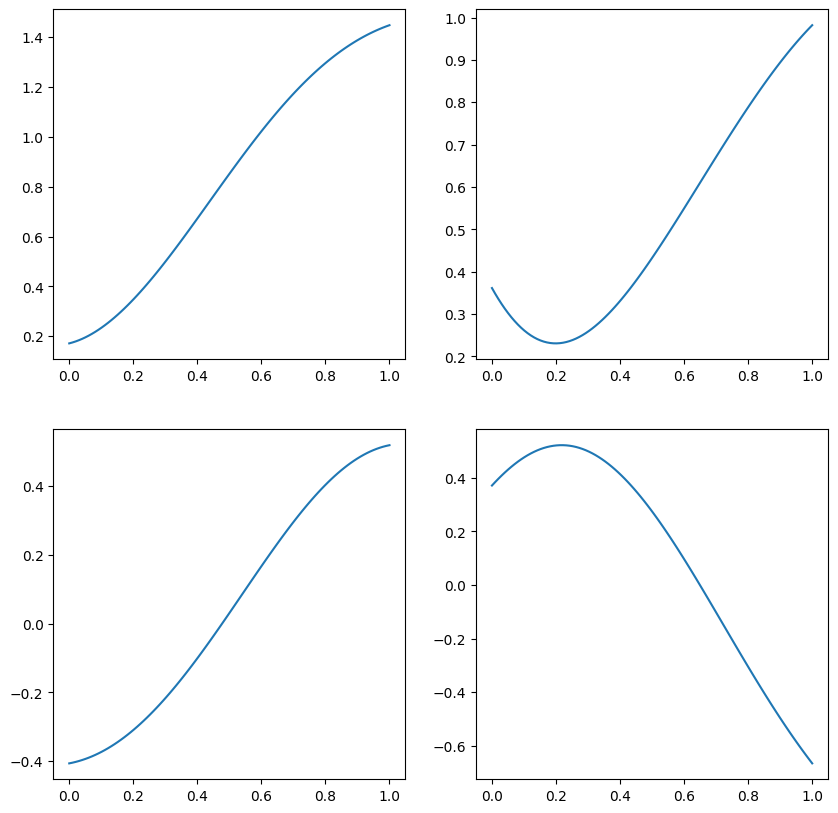

In [128]:
# Inspect generated data
length_scale = 0.6
N = 20
X_sample = np.linspace(0, 1, 100).reshape(-1, 1)
y_sample = create_samples(length_scale, N)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]])

### 2. Organize dataset for PI-DeepONet

In [129]:
def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.

    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)

    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """

    # Create random fields
    random_field = create_samples(length_scale, N)

    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]),
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)

    return X, y

In [130]:
# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 459.78it/s]


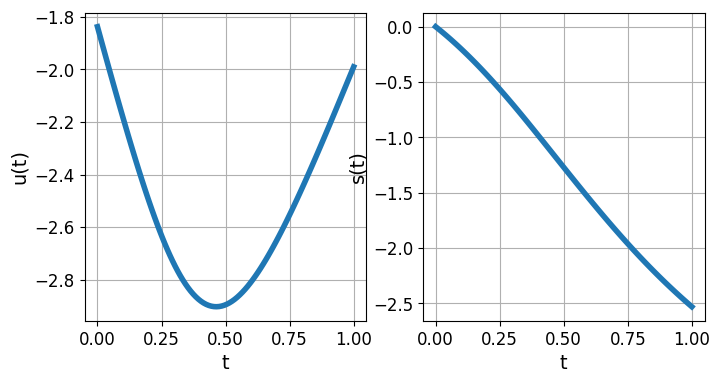

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
index = 25
ax[0].plot(np.linspace(0, 1, 100), X_test[index*100, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u(t)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(np.linspace(0, 1, 100), y_test[index*100:(index+1)*100], lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True)

#### Separate initial condition and collocation points

In [132]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

### 3. Physics-informed DeepONet

#### Define a custom layer for adding a bias

In [133]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

#### Define Physics-informed DeepONet

In [134]:
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing']),), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time']),), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)

    # Compute the dot product between branch and trunk net
    dot_product = tf.keras.ops.sum(tf.keras.ops.multiply(branch, trunk), axis=1, keepdims=True)

    # Add the bias
    output = BiasLayer()(dot_product)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

#### ODE loss

In [135]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})

    # Calculate gradients
    ds_dt = tape.gradient(s, t)

    # ODE residual
    ODE_residual = ds_dt - u_t

    return ODE_residual

#### Gradient descent step

In [136]:
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        #tape.watch(model.trainable_variables)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        IC_loss_fn = tf.keras.losses.MeanSquaredError()
        IC_loss = IC_loss_fn(y_true=0, y_pred=y_pred_IC)


        #IC_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

#### Define Loss Tracking class

In [137]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
      # Reset the metrics by reinitializing them
        self.mean_total_loss = tf.keras.metrics.Mean()
        self.mean_IC_loss = tf.keras.metrics.Mean()
        self.mean_ODE_loss = tf.keras.metrics.Mean()

        #self.mean_total_loss.reset_states()
        #self.mean_IC_loss.reset_states()
        #self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

#### Training

In [140]:
# Set up training configurations
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.keras', monitor='val_loss', save_best_only=True)]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for X_init, X in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init,
                                                                IC_weight, ODE_weight,
                                                                PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        ####### Validation
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC_fn = tf.keras.losses.MeanSquaredError()
        val_IC = val_IC_fn(0, pred_ini_valid)
        #val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.learning_rate.numpy():.2e}")

        #print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")

        # Predict on one specific train samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"forcing": X_test[sample_id*100:(sample_id+1)*100, 1:-1],
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))

        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=4.7706e-02,               ODE=2.7824e-01,               total_loss=3.2595e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
val_IC: 4.9030e-03, val_ODE: 5.7542e-02, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
RMSE: 0.09534683184794678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 2:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.9417e-03,               ODE=4.0785e-02,               total_loss=4.3727e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 2.2815e-03, val_ODE: 3.4481e-02, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
RMSE: 0.06833392084989992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 3:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.9770e-03,               ODE=2.6661e-02,               total_loss=2.8639e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
val_IC: 1.8373e-03, val_ODE: 2.4696e-02, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.05870660193418283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 4:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4976e-03,               ODE=1.9980e-02,               total_loss=2.1478e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 1.5704e-03, val_ODE: 1.9899e-02, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.060538302288226216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 5:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0271e-03,               ODE=1.5997e-02,               total_loss=1.7024e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
val_IC: 9.5312e-04, val_ODE: 1.5324e-02, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE: 0.03933168151186355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 6:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.4661e-04,               ODE=1.2791e-02,               total_loss=1.3438e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 5.2983e-04, val_ODE: 1.2763e-02, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE: 0.03482440936640052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 7:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.8270e-04,               ODE=1.0464e-02,               total_loss=1.0946e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 6.9012e-04, val_ODE: 1.0264e-02, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.027984548808977456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 8:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.3043e-04,               ODE=8.3458e-03,               total_loss=8.7762e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 4.3401e-04, val_ODE: 7.9691e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.025508311518797438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 9:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.9827e-04,               ODE=6.0559e-03,               total_loss=6.4542e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
val_IC: 4.0411e-04, val_ODE: 6.3725e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
RMSE: 0.027773360481751556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 10:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.8064e-04,               ODE=4.6084e-03,               total_loss=4.9890e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 5.0396e-04, val_ODE: 4.4297e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.024359396058656713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 11:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.3093e-04,               ODE=3.5938e-03,               total_loss=3.9248e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 2.8447e-04, val_ODE: 4.2750e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
RMSE: 0.023575232384082476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 12:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.5494e-04,               ODE=3.3908e-03,               total_loss=3.6458e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.9812e-04, val_ODE: 3.4141e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.020080530680851385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 13:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.1930e-04,               ODE=3.1143e-03,               total_loss=3.3336e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.9116e-04, val_ODE: 3.8809e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.026197971771392513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 14:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.4502e-04,               ODE=2.6971e-03,               total_loss=2.9421e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.3363e-04, val_ODE: 3.0899e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.018643111311161528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 15:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.8432e-04,               ODE=2.8391e-03,               total_loss=3.0234e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.6501e-04, val_ODE: 2.9673e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.0227180588433379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 16:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.5565e-04,               ODE=2.3650e-03,               total_loss=2.5206e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 3.3345e-04, val_ODE: 2.5908e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
RMSE: 0.022422535743027154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 17:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4053e-04,               ODE=2.4455e-03,               total_loss=2.5860e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 9.9946e-05, val_ODE: 4.0278e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE: 0.02626805685979082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 18:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1836e-04,               ODE=2.2417e-03,               total_loss=2.3600e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 9.1549e-05, val_ODE: 2.3822e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.016719687993620586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 19:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.3502e-04,               ODE=2.8369e-03,               total_loss=3.0719e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 1.5900e-04, val_ODE: 2.4840e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.015954043808809583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 20:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.2654e-04,               ODE=1.8818e-03,               total_loss=2.0083e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 8.1187e-05, val_ODE: 2.4600e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.017516879581622905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 21:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0641e-04,               ODE=1.9787e-03,               total_loss=2.0851e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 8.5576e-05, val_ODE: 1.8072e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE: 0.012765008727579595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 22:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.0541e-05,               ODE=1.9493e-03,               total_loss=2.0398e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 2.7285e-04, val_ODE: 2.9945e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.01688595412615398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 23:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1161e-04,               ODE=1.9747e-03,               total_loss=2.0863e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
val_IC: 8.1414e-05, val_ODE: 1.6574e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.013029008790830156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 24:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.7729e-05,               ODE=1.8415e-03,               total_loss=1.9192e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 6.1889e-05, val_ODE: 2.0980e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.015720964156433186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 25:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1904e-04,               ODE=1.8124e-03,               total_loss=1.9315e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 6.7586e-05, val_ODE: 1.7606e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.012521753632579973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 26:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.6021e-05,               ODE=1.8961e-03,               total_loss=1.9721e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 1.1911e-04, val_ODE: 3.9749e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.033255569738618214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 27:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.3752e-05,               ODE=1.7428e-03,               total_loss=1.8265e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 8.4530e-05, val_ODE: 1.5688e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.010779358326826693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 28:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.0867e-05,               ODE=1.5827e-03,               total_loss=1.6735e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 6.7967e-05, val_ODE: 1.4502e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.010742398640656157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 29:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0552e-04,               ODE=1.6903e-03,               total_loss=1.7958e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 5.3835e-05, val_ODE: 1.6686e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.012772090914102327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 30:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.2799e-05,               ODE=1.9927e-03,               total_loss=2.0755e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 2.1612e-04, val_ODE: 1.9020e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.017632989653131457
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 31:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.9669e-05,               ODE=1.3971e-03,               total_loss=1.4767e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.4984e-04, val_ODE: 1.9489e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.013302950881977828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 32:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.3537e-05,               ODE=1.7769e-03,               total_loss=1.8504e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 2.0040e-04, val_ODE: 1.9137e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.02312675720454144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 33:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.2061e-04,               ODE=1.6899e-03,               total_loss=1.8105e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.1593e-04, val_ODE: 2.6125e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.014726563434115266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 34:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1819e-04,               ODE=1.5504e-03,               total_loss=1.6686e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
val_IC: 8.0101e-05, val_ODE: 1.6307e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
RMSE: 0.011653182588883081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 35:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0768e-05,               ODE=1.4343e-03,               total_loss=1.5051e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 6.6268e-05, val_ODE: 1.9241e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.024447792343819205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 36:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0950e-04,               ODE=1.4371e-03,               total_loss=1.5466e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.3848e-05, val_ODE: 1.5775e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.019003193510917196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 37:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3958e-04,               ODE=1.9706e-03,               total_loss=2.1102e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.2692e-04, val_ODE: 1.9647e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.01687912264946429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 38:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.0186e-05,               ODE=1.0791e-03,               total_loss=1.1293e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 4.0708e-05, val_ODE: 1.2808e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.017525233946050198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 39:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.2412e-05,               ODE=1.1065e-03,               total_loss=1.1689e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 5.8421e-05, val_ODE: 9.1191e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.008888989373739652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 40:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.9989e-05,               ODE=1.4884e-03,               total_loss=1.5784e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 7.0437e-05, val_ODE: 1.5521e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.018786399757432373
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 41:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.8027e-05,               ODE=1.0247e-03,               total_loss=1.0727e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 3.1631e-05, val_ODE: 8.0001e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.00825919714310195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 42:
IC=8.0191e-05,               ODE=1.1685e-03,               total_loss=1.2486e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 6.0973e-05, val_ODE: 1.3772e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.019849942852518933
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 43:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.3234e-05,               ODE=1.6801e-03,               total_loss=1.7734e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.2575e-04, val_ODE: 1.3429e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.02278139636146956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 44:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1220e-04,               ODE=7.1100e-04,               total_loss=8.2319e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 2.9336e-05, val_ODE: 5.6066e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.009179813444962435
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 45:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1369e-05,               ODE=8.3221e-04,               total_loss=8.9358e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.9962e-05, val_ODE: 1.2965e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.010500088244417121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 46:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.2739e-05,               ODE=9.3366e-04,               total_loss=1.0064e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 5.9980e-05, val_ODE: 5.8540e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.010027907584488712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 47:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.5694e-05,               ODE=8.2195e-04,               total_loss=8.7764e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 3.6313e-05, val_ODE: 6.2637e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.008838247882842033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 48:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.7255e-05,               ODE=7.6178e-04,               total_loss=8.1903e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 5.9862e-05, val_ODE: 7.7394e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.010554125208810078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 49:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.6017e-05,               ODE=8.3303e-04,               total_loss=8.9905e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 4.7002e-05, val_ODE: 7.3561e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
RMSE: 0.014457098365654052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 50:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.6502e-05,               ODE=1.2777e-03,               total_loss=1.3742e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 2.1483e-04, val_ODE: 1.0849e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
RMSE: 0.02324710268686813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 51:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.5972e-05,               ODE=5.6547e-04,               total_loss=6.3145e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.5896e-04, val_ODE: 4.4037e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.01678432732855807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 52:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.0510e-05,               ODE=6.2863e-04,               total_loss=6.8914e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 5.1362e-05, val_ODE: 7.9268e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.01795560405123378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 53:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.2223e-05,               ODE=7.3788e-04,               total_loss=7.8010e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 1.8629e-05, val_ODE: 5.1915e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.009211374485966097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 54:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.1417e-05,               ODE=7.3245e-04,               total_loss=7.7387e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.8446e-05, val_ODE: 5.5922e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.007456867636875221
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 55:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9926e-05,               ODE=6.6824e-04,               total_loss=7.2817e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
val_IC: 4.1570e-05, val_ODE: 4.7549e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.010758207589188088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 56:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.0262e-05,               ODE=9.5100e-04,               total_loss=1.0113e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 2.4904e-05, val_ODE: 4.7294e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.00975930683532855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 57:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.8750e-05,               ODE=5.8938e-04,               total_loss=6.2813e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 6.5381e-05, val_ODE: 4.6791e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.011060166613632714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 58:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1002e-04,               ODE=8.3488e-04,               total_loss=9.4490e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 1.2186e-04, val_ODE: 4.4230e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.009883876826394786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 59:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0050e-05,               ODE=7.1931e-04,               total_loss=7.8936e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.9438e-05, val_ODE: 3.2796e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.006865963115107115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 60:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.8304e-05,               ODE=1.0782e-03,               total_loss=1.1265e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
val_IC: 4.7109e-05, val_ODE: 4.0511e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
RMSE: 0.010873755638030828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 61:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.2433e-05,               ODE=4.5459e-04,               total_loss=4.8702e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 5.1646e-05, val_ODE: 7.5133e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.014972543818451365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 62:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.9242e-05,               ODE=7.7817e-04,               total_loss=8.2741e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 2.6954e-05, val_ODE: 5.7185e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
RMSE: 0.008407599783658796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 63:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.7907e-05,               ODE=5.8477e-04,               total_loss=6.2268e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
val_IC: 2.1501e-05, val_ODE: 3.8714e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
RMSE: 0.006157833170233342
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 64:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.6418e-05,               ODE=9.2726e-04,               total_loss=1.0037e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 3.1472e-05, val_ODE: 3.3733e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.00801656991033657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 65:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.7022e-05,               ODE=6.3226e-04,               total_loss=6.7928e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 6.1571e-05, val_ODE: 4.1530e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
RMSE: 0.01051079818663481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 66:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.6572e-05,               ODE=9.2516e-04,               total_loss=1.0017e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 3.6559e-05, val_ODE: 1.1586e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.011139506243336187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 67:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.7569e-05,               ODE=6.2927e-04,               total_loss=6.6684e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 4.1343e-05, val_ODE: 3.9084e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RMSE: 0.015315035133427433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 68:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.7913e-05,               ODE=5.7318e-04,               total_loss=6.3110e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 3.1586e-05, val_ODE: 2.2675e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.027959749508872797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 69:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.6775e-05,               ODE=8.4121e-04,               total_loss=8.8799e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 3.7807e-05, val_ODE: 6.4622e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.011406301360084557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 70:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0335e-05,               ODE=5.3244e-04,               total_loss=6.0278e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 2.7789e-05, val_ODE: 2.9977e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.007315434643566405


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 71:
IC=6.4281e-05,               ODE=9.5297e-04,               total_loss=1.0173e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 3.4617e-05, val_ODE: 4.1872e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.006267142850332499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 72:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.5304e-05,               ODE=5.1231e-04,               total_loss=5.5761e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 2.3351e-05, val_ODE: 5.4962e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
RMSE: 0.011293747463627147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 73:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.2259e-05,               ODE=8.3284e-04,               total_loss=8.7510e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 4.1204e-05, val_ODE: 1.2407e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.014437930254994954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 74:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.4130e-05,               ODE=5.4678e-04,               total_loss=6.0091e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 2.3447e-05, val_ODE: 8.6002e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.01487142183762338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 75:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.3060e-05,               ODE=7.3183e-04,               total_loss=7.7489e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 4.9570e-05, val_ODE: 9.1834e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.015299343892091841
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 76:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.1516e-05,               ODE=6.9629e-04,               total_loss=7.3780e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 2.1650e-05, val_ODE: 5.2258e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
RMSE: 0.009986658758814873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 77:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.1479e-05,               ODE=8.6818e-04,               total_loss=9.0966e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
val_IC: 7.5650e-05, val_ODE: 4.1433e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.00701173198871492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 78:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3843e-05,               ODE=5.3830e-04,               total_loss=5.9215e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
val_IC: 7.2986e-05, val_ODE: 7.1877e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.021390688127771132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 79:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.8677e-05,               ODE=8.2948e-04,               total_loss=8.9816e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 3.4076e-05, val_ODE: 4.3469e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
RMSE: 0.009319370301800554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 80:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.3787e-05,               ODE=6.8003e-04,               total_loss=7.1381e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 6.3178e-05, val_ODE: 3.2387e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.008839159429431897
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 81:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.3498e-05,               ODE=6.2669e-04,               total_loss=6.6019e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 9.8421e-06, val_ODE: 3.3398e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.006529596917514179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 82:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.3563e-05,               ODE=6.1087e-04,               total_loss=6.4444e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 7.1800e-05, val_ODE: 6.0829e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.009686941119350105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 83:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.4396e-05,               ODE=6.9571e-04,               total_loss=7.2010e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.0139e-05, val_ODE: 5.4847e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.009741757661070282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 84:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.8262e-05,               ODE=4.9245e-04,               total_loss=5.4071e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 4.5510e-05, val_ODE: 4.2199e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.009461618193880403
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 85:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.4369e-05,               ODE=7.9231e-04,               total_loss=8.3668e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 6.1765e-05, val_ODE: 5.9089e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.014941423634719302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 86:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.6690e-05,               ODE=4.9147e-04,               total_loss=5.1816e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 7.3290e-05, val_ODE: 2.0897e-03, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.023452661421841527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 87:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.4391e-05,               ODE=7.1997e-04,               total_loss=7.7436e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 2.8702e-05, val_ODE: 4.1932e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.010958548499254244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 88:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.8323e-05,               ODE=4.9888e-04,               total_loss=5.2720e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 1.1777e-05, val_ODE: 3.6309e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
RMSE: 0.011997168858886437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 89:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.6766e-05,               ODE=1.1733e-03,               total_loss=1.2601e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 5.6618e-05, val_ODE: 4.6002e-04, lr: 1.00e-03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
RMSE: 0.010297447876129443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 90:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4288e-05,               ODE=2.0523e-04,               total_loss=2.1952e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 7.0475e-06, val_ODE: 2.2005e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.004968363131472753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 91:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.1570e-06,               ODE=1.6824e-04,               total_loss=1.7640e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 5.3841e-06, val_ODE: 1.9115e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0042680359116368674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 92:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.0801e-06,               ODE=1.5700e-04,               total_loss=1.6508e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 7.2291e-06, val_ODE: 1.9039e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
RMSE: 0.0038898543698845144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 93:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.0627e-06,               ODE=1.5448e-04,               total_loss=1.6254e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 5.7468e-06, val_ODE: 1.8992e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0041245662678216334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 94:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.7415e-06,               ODE=1.4195e-04,               total_loss=1.4870e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 4.4873e-06, val_ODE: 1.8313e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.003915819196768002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 95:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.6497e-06,               ODE=1.3808e-04,               total_loss=1.4373e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
val_IC: 4.3486e-06, val_ODE: 1.7550e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.00356536149208119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 96:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9388e-06,               ODE=1.4651e-04,               total_loss=1.5245e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 7.4787e-06, val_ODE: 1.7879e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.004325300361428737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 97:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.2905e-06,               ODE=1.5478e-04,               total_loss=1.6107e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 6.2713e-06, val_ODE: 1.6524e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.003508486758758202
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 98:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.2774e-06,               ODE=1.5085e-04,               total_loss=1.5613e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 6.8236e-06, val_ODE: 1.8027e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.004704913919577282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 99:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.4708e-06,               ODE=1.8768e-04,               total_loss=1.9315e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 6.1809e-06, val_ODE: 1.8771e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.003853645429034963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 100:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.3211e-06,               ODE=2.7560e-04,               total_loss=2.8392e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 7.2330e-06, val_ODE: 1.6372e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.004125170652846633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 101:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.7749e-06,               ODE=1.8684e-04,               total_loss=1.9261e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 4.5190e-06, val_ODE: 1.8497e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
RMSE: 0.00420900258553562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 102:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.7145e-06,               ODE=3.0850e-04,               total_loss=3.1721e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 3.0510e-06, val_ODE: 1.5255e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.0033175874064481047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 103:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.9601e-06,               ODE=1.8379e-04,               total_loss=1.9075e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.8098e-06, val_ODE: 2.3130e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.004715534311329379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 104:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.9821e-06,               ODE=2.1209e-04,               total_loss=2.2107e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 6.1940e-06, val_ODE: 2.0815e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.004896866787772829
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 105:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.2440e-05,               ODE=2.5543e-04,               total_loss=2.6787e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 3.9566e-06, val_ODE: 2.9342e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.007136141610016453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 106:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.5888e-06,               ODE=2.7111e-04,               total_loss=2.8070e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 6.5365e-06, val_ODE: 3.4805e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.005840586714526242
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 107:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0934e-05,               ODE=3.5148e-04,               total_loss=3.6241e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.0166e-05, val_ODE: 2.6430e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.004409680755329026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 108:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.8192e-06,               ODE=1.8051e-04,               total_loss=1.8833e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 3.4784e-06, val_ODE: 1.4278e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0038329519503783583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 109:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3265e-05,               ODE=2.5205e-04,               total_loss=2.6532e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 1.4131e-05, val_ODE: 1.9350e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.005980924398157481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 110:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1394e-05,               ODE=2.6956e-04,               total_loss=2.8096e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 6.2880e-06, val_ODE: 2.4351e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.005532554587515936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 111:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1186e-06,               ODE=2.0474e-04,               total_loss=2.1086e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 7.0066e-06, val_ODE: 5.2908e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.006839362503118488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 112:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.1981e-06,               ODE=2.6704e-04,               total_loss=2.7424e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.4659e-05, val_ODE: 2.9827e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
RMSE: 0.010216672148239432
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 113:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.2354e-05,               ODE=2.5217e-04,               total_loss=2.6452e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.2097e-05, val_ODE: 2.5180e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.009894843073768169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 114:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1478e-05,               ODE=2.4422e-04,               total_loss=2.5570e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 1.3370e-05, val_ODE: 2.5328e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.006806722286141902
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 115:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0145e-05,               ODE=3.3059e-04,               total_loss=3.4073e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.0215e-05, val_ODE: 2.3835e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
RMSE: 0.005011763742298474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 116:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0899e-05,               ODE=2.2544e-04,               total_loss=2.3634e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
val_IC: 5.9928e-06, val_ODE: 5.2072e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
RMSE: 0.013610595871271986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 117:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1413e-05,               ODE=2.3775e-04,               total_loss=2.4916e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 9.5377e-06, val_ODE: 2.1233e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
RMSE: 0.005522307259084013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 118:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.8393e-06,               ODE=2.2361e-04,               total_loss=2.3245e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 6.7382e-06, val_ODE: 1.4093e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.004196960123949646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 119:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0693e-05,               ODE=2.2896e-04,               total_loss=2.3965e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 8.2081e-06, val_ODE: 1.7740e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
RMSE: 0.006685690026752784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 120:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.9208e-06,               ODE=1.9752e-04,               total_loss=2.0644e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.4466e-06, val_ODE: 2.4574e-04, lr: 5.00e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.007339872724271065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 121:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.7430e-06,               ODE=1.0432e-04,               total_loss=1.0806e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 2.0487e-06, val_ODE: 1.1529e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.002832579905318134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 122:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.7161e-06,               ODE=9.2743e-05,               total_loss=9.5460e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 2.1187e-06, val_ODE: 1.1887e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
RMSE: 0.0027293509284702093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 123:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.6127e-06,               ODE=9.2398e-05,               total_loss=9.5011e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
val_IC: 1.8071e-06, val_ODE: 1.1255e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.0025767378331223597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 124:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.7362e-06,               ODE=8.8915e-05,               total_loss=9.1651e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 7.2684e-06, val_ODE: 1.1362e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0035525124353118945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 125:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.3579e-06,               ODE=9.1381e-05,               total_loss=9.4739e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
val_IC: 1.9692e-06, val_ODE: 1.1202e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
RMSE: 0.002571527746930039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 126:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.5144e-06,               ODE=9.0999e-05,               total_loss=9.3513e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 3.1559e-06, val_ODE: 1.0562e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.0028635406539127117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 127:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.4310e-06,               ODE=8.8991e-05,               total_loss=9.1422e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.3861e-06, val_ODE: 1.0832e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.003009781064901035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 128:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.8319e-06,               ODE=8.7642e-05,               total_loss=9.0473e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.9298e-06, val_ODE: 1.1255e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE: 0.0025277399970900427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 129:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.5984e-06,               ODE=9.1205e-05,               total_loss=9.4803e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
val_IC: 8.7001e-06, val_ODE: 1.0957e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.003717786734952073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 130:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.2410e-06,               ODE=8.6023e-05,               total_loss=9.0264e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 2.1934e-06, val_ODE: 9.8861e-05, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0028508402512597486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 131:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.9587e-06,               ODE=1.0029e-04,               total_loss=1.0324e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.3386e-06, val_ODE: 1.0787e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0029287886015521448
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 132:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.4728e-06,               ODE=1.0646e-04,               total_loss=1.0893e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.2797e-06, val_ODE: 1.0118e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0028667670207600986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 133:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.1700e-06,               ODE=1.2041e-04,               total_loss=1.2358e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 5.4116e-06, val_ODE: 1.0243e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0026345092503955673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 134:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.1588e-06,               ODE=9.6728e-05,               total_loss=9.9886e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 2.9519e-06, val_ODE: 1.0589e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.003491633238529298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 135:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.2345e-06,               ODE=1.5821e-04,               total_loss=1.6145e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
val_IC: 3.4182e-06, val_ODE: 1.2845e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
RMSE: 0.004449310216856494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 136:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.3311e-06,               ODE=8.7174e-05,               total_loss=8.9505e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 3.4101e-06, val_ODE: 1.0396e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0030593449072706955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 137:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.7484e-06,               ODE=1.0597e-04,               total_loss=1.0872e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.6175e-06, val_ODE: 1.0348e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0024810041853745636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 138:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=4.1934e-06,               ODE=1.5610e-04,               total_loss=1.6029e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
val_IC: 4.0421e-06, val_ODE: 1.0845e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0026161716188150327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 139:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.9906e-06,               ODE=1.0119e-04,               total_loss=1.0518e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 3.4365e-06, val_ODE: 9.3438e-05, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0032418070537502015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 140:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.9500e-06,               ODE=1.0786e-04,               total_loss=1.1081e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 3.5598e-06, val_ODE: 9.3094e-05, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.002710292678179922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 141:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.9820e-06,               ODE=9.9465e-05,               total_loss=1.0245e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 2.6733e-06, val_ODE: 1.0032e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.002438590132127817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 142:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.4187e-06,               ODE=1.1617e-04,               total_loss=1.1959e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.0285e-06, val_ODE: 1.7640e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.003811907071259386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 143:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.5243e-06,               ODE=1.2878e-04,               total_loss=1.3530e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.2683e-06, val_ODE: 1.0198e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
RMSE: 0.002858359957709563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 144:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.5233e-06,               ODE=1.1867e-04,               total_loss=1.2220e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
val_IC: 3.9414e-06, val_ODE: 1.4183e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.005161361771138921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 145:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.9745e-06,               ODE=8.0138e-05,               total_loss=8.4112e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 7.6221e-06, val_ODE: 1.0091e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.004761931253834893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 146:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.9207e-06,               ODE=1.1325e-04,               total_loss=1.1717e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.2317e-06, val_ODE: 8.5391e-05, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0023947308736707008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 147:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.6994e-06,               ODE=1.1895e-04,               total_loss=1.2165e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 2.5707e-06, val_ODE: 1.1171e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.003231428754662537
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 148:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.6461e-06,               ODE=9.4246e-05,               total_loss=9.6892e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 4.1884e-06, val_ODE: 8.8170e-05, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0032627666689193876
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 149:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.7914e-06,               ODE=1.2473e-04,               total_loss=1.2852e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 7.2218e-06, val_ODE: 9.3467e-05, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.003827073397571528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 150:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.3306e-06,               ODE=8.5464e-05,               total_loss=8.8795e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 7.8927e-06, val_ODE: 1.0333e-04, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.00455314660984328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 151:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=3.6461e-06,               ODE=9.4923e-05,               total_loss=9.8569e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 3.3373e-06, val_ODE: 7.9128e-05, lr: 2.50e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.00273199370479554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 152:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.6624e-06,               ODE=5.5569e-05,               total_loss=5.7231e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.8074e-07, val_ODE: 6.6951e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.002130819094834276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 153:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3393e-06,               ODE=5.3338e-05,               total_loss=5.4677e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.2274e-06, val_ODE: 6.7842e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.001997481255144771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 154:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3892e-06,               ODE=5.3035e-05,               total_loss=5.4424e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.6990e-06, val_ODE: 6.6119e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0021815250817015723
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 155:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4302e-06,               ODE=5.3262e-05,               total_loss=5.4692e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 1.9083e-06, val_ODE: 6.4181e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0021433845901836154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 156:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.2883e-06,               ODE=5.3003e-05,               total_loss=5.4291e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.2824e-06, val_ODE: 6.8507e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.002101702429548549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 157:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4545e-06,               ODE=5.1269e-05,               total_loss=5.2723e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 9.2494e-07, val_ODE: 6.5345e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.002096175522785073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 158:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.5994e-06,               ODE=5.2990e-05,               total_loss=5.4590e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.5883e-06, val_ODE: 6.8651e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.0023101179627569566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 159:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3544e-06,               ODE=5.1728e-05,               total_loss=5.3082e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.7520e-06, val_ODE: 6.1032e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.002006274461235553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 160:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4498e-06,               ODE=5.1096e-05,               total_loss=5.2546e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.4120e-06, val_ODE: 6.6905e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0017763546052146334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 161:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3176e-06,               ODE=5.3840e-05,               total_loss=5.5158e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 1.1524e-06, val_ODE: 6.5919e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0024679546700450026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 162:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.6584e-06,               ODE=5.1041e-05,               total_loss=5.2699e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 1.7474e-06, val_ODE: 5.9288e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.002370531998341595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 163:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.5285e-06,               ODE=5.3302e-05,               total_loss=5.4831e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.5016e-06, val_ODE: 6.7764e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.00313917459438568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 164:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3010e-06,               ODE=5.4174e-05,               total_loss=5.5475e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.3894e-06, val_ODE: 6.7409e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.003461595168705255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 165:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.5806e-06,               ODE=5.2374e-05,               total_loss=5.3955e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 2.2016e-06, val_ODE: 8.4503e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
RMSE: 0.0032724453128329975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 166:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4114e-06,               ODE=5.4099e-05,               total_loss=5.5511e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 9.7881e-07, val_ODE: 6.6117e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0023584960207661348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 167:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.7398e-06,               ODE=5.5279e-05,               total_loss=5.7019e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.6203e-06, val_ODE: 6.9659e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0027503811813357217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 168:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=2.0481e-06,               ODE=5.3624e-05,               total_loss=5.5672e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 5.0166e-06, val_ODE: 8.6933e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.003194764279335511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 169:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.9841e-06,               ODE=6.8939e-05,               total_loss=7.0923e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 3.2111e-06, val_ODE: 5.3909e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
RMSE: 0.0033673022830882516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 170:
IC=1.5489e-06,               ODE=5.0937e-05,               total_loss=5.2486e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.2790e-06, val_ODE: 5.7361e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.002328782876915527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 171:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.6021e-06,               ODE=5.3207e-05,               total_loss=5.4809e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 3.1583e-06, val_ODE: 6.0386e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
RMSE: 0.0020810275817738626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 172:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4074e-06,               ODE=4.6554e-05,               total_loss=4.7961e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 2.0113e-06, val_ODE: 5.7961e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0018737206467644076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 173:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4935e-06,               ODE=6.5784e-05,               total_loss=6.7278e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 1.0746e-06, val_ODE: 8.0958e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
RMSE: 0.003449156413663725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 174:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4990e-06,               ODE=5.2483e-05,               total_loss=5.3982e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.2655e-06, val_ODE: 5.4431e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0019589652335413378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 175:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3728e-06,               ODE=4.5556e-05,               total_loss=4.6929e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.5947e-06, val_ODE: 5.4279e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
RMSE: 0.0017821841461355813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 176:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.3297e-06,               ODE=4.6299e-05,               total_loss=4.7629e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.1849e-06, val_ODE: 6.1478e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.002061676947037787
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 177:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4531e-06,               ODE=5.4052e-05,               total_loss=5.5505e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 1.3878e-06, val_ODE: 5.5219e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.0019476614700031378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 178:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.7114e-06,               ODE=5.1887e-05,               total_loss=5.3598e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 8.5797e-07, val_ODE: 5.9173e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.002203621793885186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 179:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4259e-06,               ODE=4.8783e-05,               total_loss=5.0209e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 1.5159e-06, val_ODE: 5.3792e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.001985761152119911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 180:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.8704e-06,               ODE=6.1948e-05,               total_loss=6.3818e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.4366e-06, val_ODE: 4.7925e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0022288165304990043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 181:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.4912e-06,               ODE=4.6602e-05,               total_loss=4.8093e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 1.7080e-06, val_ODE: 6.5868e-05, lr: 1.25e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.002727805678572415
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 182:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.2598e-07,               ODE=3.4958e-05,               total_loss=3.5784e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 8.8878e-07, val_ODE: 4.4729e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0016508464570235224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 183:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.5563e-07,               ODE=3.4094e-05,               total_loss=3.4949e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.0013e-06, val_ODE: 4.6455e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0018540542997010495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 184:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.9227e-07,               ODE=3.4346e-05,               total_loss=3.5138e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 9.9231e-07, val_ODE: 4.5448e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0018083022503906521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 185:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.8898e-07,               ODE=3.3725e-05,               total_loss=3.4614e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.6026e-07, val_ODE: 4.3565e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.00176370901382914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 186:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.1827e-07,               ODE=3.3226e-05,               total_loss=3.4144e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 7.6925e-07, val_ODE: 4.3256e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0018441261171229747
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 187:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.2258e-07,               ODE=3.2720e-05,               total_loss=3.3642e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 6.9447e-07, val_ODE: 4.4324e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0016563065703664355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 188:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.1806e-07,               ODE=3.3566e-05,               total_loss=3.4385e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 1.1802e-06, val_ODE: 4.4360e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
RMSE: 0.0017902879494118128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 189:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.4262e-07,               ODE=3.3767e-05,               total_loss=3.4710e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 1.3744e-06, val_ODE: 4.7926e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.00229204764353592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 190:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.8111e-07,               ODE=3.2751e-05,               total_loss=3.3732e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 7.3665e-07, val_ODE: 4.2539e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.001746923043353424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 191:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.8570e-07,               ODE=3.3926e-05,               total_loss=3.4911e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.4582e-07, val_ODE: 4.4254e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0017282518554635987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 192:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.3182e-07,               ODE=3.2851e-05,               total_loss=3.3783e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 8.5261e-07, val_ODE: 4.4432e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0021161220388639444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 193:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.3568e-07,               ODE=3.3336e-05,               total_loss=3.4272e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
val_IC: 7.4775e-07, val_ODE: 4.1879e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
RMSE: 0.0017411499786996255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 194:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.7249e-07,               ODE=3.4548e-05,               total_loss=3.5520e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 5.7870e-07, val_ODE: 4.5306e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0017284180207622487
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 195:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.5661e-07,               ODE=3.3466e-05,               total_loss=3.4322e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 1.5935e-06, val_ODE: 4.6971e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0017021056781207596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 196:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.3191e-07,               ODE=3.2960e-05,               total_loss=3.3892e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.7202e-07, val_ODE: 4.8453e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.001715868477580505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 197:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.5972e-07,               ODE=3.3357e-05,               total_loss=3.4217e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 8.2139e-07, val_ODE: 4.2557e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0018223512470687583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 198:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.9512e-07,               ODE=3.2733e-05,               total_loss=3.3728e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 8.6082e-07, val_ODE: 4.5819e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.002318672190243606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 199:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0646e-06,               ODE=3.2777e-05,               total_loss=3.3842e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.3294e-06, val_ODE: 4.1792e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
RMSE: 0.0018834916105580956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 200:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.0592e-06,               ODE=3.2707e-05,               total_loss=3.3766e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 6.6360e-07, val_ODE: 4.3478e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
RMSE: 0.00231584595307749
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 201:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1087e-06,               ODE=3.2734e-05,               total_loss=3.3842e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 1.4182e-06, val_ODE: 4.0966e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0020031070142664626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 202:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=1.1202e-06,               ODE=3.2958e-05,               total_loss=3.4078e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 6.0586e-07, val_ODE: 3.9983e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0017631855454934905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 203:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.3477e-07,               ODE=3.1436e-05,               total_loss=3.2270e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
val_IC: 9.1456e-07, val_ODE: 4.5541e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
RMSE: 0.0021583186374530493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 204:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.4780e-07,               ODE=3.3861e-05,               total_loss=3.4709e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.1509e-07, val_ODE: 3.8116e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE: 0.0016081393046453814
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 205:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.4004e-07,               ODE=3.3420e-05,               total_loss=3.4360e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 9.7067e-07, val_ODE: 5.2013e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0022847965495720536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 206:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.5402e-07,               ODE=3.1115e-05,               total_loss=3.2069e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 8.3564e-07, val_ODE: 4.1077e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0020430665994683682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 207:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.4716e-07,               ODE=3.1600e-05,               total_loss=3.2447e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 8.6332e-07, val_ODE: 3.8986e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.0021036947232835656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 208:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.7045e-07,               ODE=3.1316e-05,               total_loss=3.2286e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.4518e-06, val_ODE: 3.7444e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0018844622238820279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 209:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.7787e-07,               ODE=3.0448e-05,               total_loss=3.1426e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 1.7406e-06, val_ODE: 3.7238e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0017568662496841871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 210:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.7765e-07,               ODE=3.1156e-05,               total_loss=3.2134e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.7587e-07, val_ODE: 4.2957e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
RMSE: 0.002447418287032397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 211:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=9.9579e-07,               ODE=3.1669e-05,               total_loss=3.2665e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 7.0399e-07, val_ODE: 3.9881e-05, lr: 6.25e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0018669301947233893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 212:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0528e-07,               ODE=2.6488e-05,               total_loss=2.7193e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
val_IC: 7.3041e-07, val_ODE: 3.5699e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.0015326009623626456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 213:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.8438e-07,               ODE=2.6132e-05,               total_loss=2.6817e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.3798e-07, val_ODE: 3.5085e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015219758120985332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 214:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.1474e-07,               ODE=2.5952e-05,               total_loss=2.6667e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 9.1809e-07, val_ODE: 3.5958e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015911337095759872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 215:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.1445e-07,               ODE=2.6288e-05,               total_loss=2.7003e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 8.9205e-07, val_ODE: 3.5282e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0015323620686292657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 216:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.8685e-07,               ODE=2.5929e-05,               total_loss=2.6716e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 7.4434e-07, val_ODE: 3.6324e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0016362044594234566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 217:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.3478e-07,               ODE=2.5856e-05,               total_loss=2.6591e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 6.5622e-07, val_ODE: 3.6631e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.001563727038829186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 218:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.9445e-07,               ODE=2.5927e-05,               total_loss=2.6622e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 7.3770e-07, val_ODE: 3.5786e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015127141872534294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 219:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.9209e-07,               ODE=2.5739e-05,               total_loss=2.6431e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 7.6188e-07, val_ODE: 3.4633e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0014774106441738518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 220:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.7721e-07,               ODE=2.5835e-05,               total_loss=2.6612e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 9.1065e-07, val_ODE: 3.5652e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0016296533416085925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 221:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.5688e-07,               ODE=2.5733e-05,               total_loss=2.6489e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 5.6969e-07, val_ODE: 3.6258e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015842022506677618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Epoch 222:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0352e-07,               ODE=2.5809e-05,               total_loss=2.6512e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.0611e-07, val_ODE: 3.4795e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.001549451801919311
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 223:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.7446e-07,               ODE=2.5424e-05,               total_loss=2.6198e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 9.1951e-07, val_ODE: 3.6103e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
RMSE: 0.0016203535404780472
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 224:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.7583e-07,               ODE=2.5371e-05,               total_loss=2.6247e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 1.1988e-06, val_ODE: 3.8244e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0016943241814271833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 225:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=8.0671e-07,               ODE=2.6031e-05,               total_loss=2.6838e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 6.0554e-07, val_ODE: 3.5499e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
RMSE: 0.0014978851559754494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 226:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.9029e-07,               ODE=2.5823e-05,               total_loss=2.6613e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 7.1266e-07, val_ODE: 3.4599e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0015225523437445395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 227:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.9221e-07,               ODE=2.5136e-05,               total_loss=2.5828e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 6.9121e-07, val_ODE: 3.4756e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0018075295637413745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 228:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0839e-07,               ODE=2.6612e-05,               total_loss=2.7320e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 5.9961e-07, val_ODE: 3.4809e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
RMSE: 0.0016002820640452797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 229:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.2262e-07,               ODE=2.4743e-05,               total_loss=2.5365e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 6.7271e-07, val_ODE: 3.3528e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0017256225930819696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 230:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.7866e-07,               ODE=2.5577e-05,               total_loss=2.6255e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 8.0652e-07, val_ODE: 3.4621e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0015023093822586172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 231:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.4579e-07,               ODE=2.5486e-05,               total_loss=2.6232e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 9.0337e-07, val_ODE: 3.4159e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0016826542536315485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 232:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0459e-07,               ODE=2.5063e-05,               total_loss=2.5768e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 9.3660e-07, val_ODE: 3.5842e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015653650271337037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 233:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.9457e-07,               ODE=2.5752e-05,               total_loss=2.6547e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.2410e-07, val_ODE: 3.3376e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0014384179337184303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 234:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.1294e-07,               ODE=2.5254e-05,               total_loss=2.5967e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 6.4586e-07, val_ODE: 3.4607e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015759197148894231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 235:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.0331e-07,               ODE=2.5691e-05,               total_loss=2.6394e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 5.6176e-07, val_ODE: 3.4660e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0016533491011893253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 236:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.9223e-07,               ODE=2.5632e-05,               total_loss=2.6325e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 5.5264e-07, val_ODE: 3.7016e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0016412242348230932
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 237:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.6474e-07,               ODE=2.5032e-05,               total_loss=2.5796e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 8.0598e-07, val_ODE: 3.6368e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.002138632282809122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 238:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.4111e-07,               ODE=2.4828e-05,               total_loss=2.5569e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 8.4202e-07, val_ODE: 3.4745e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
RMSE: 0.0016228283219745121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 239:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.8739e-07,               ODE=2.4408e-05,               total_loss=2.5095e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 7.8662e-07, val_ODE: 3.4205e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.001851960997353807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 240:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=7.4618e-07,               ODE=2.5291e-05,               total_loss=2.6037e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 5.8830e-07, val_ODE: 3.4162e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0015017367865400887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 241:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.8120e-07,               ODE=2.4115e-05,               total_loss=2.4796e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 1.0498e-06, val_ODE: 3.6376e-05, lr: 3.13e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
RMSE: 0.0015896657698965678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 242:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.5181e-07,               ODE=2.3010e-05,               total_loss=2.3661e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 5.4743e-07, val_ODE: 3.2298e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE: 0.0014788921366126176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 243:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.8926e-07,               ODE=2.2696e-05,               total_loss=2.3285e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 5.9702e-07, val_ODE: 3.2416e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.001406227327458045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 244:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.0960e-07,               ODE=2.2656e-05,               total_loss=2.3265e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 4.9252e-07, val_ODE: 3.4762e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
RMSE: 0.001455972952877632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 245:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.8129e-07,               ODE=2.2595e-05,               total_loss=2.3176e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 5.4452e-07, val_ODE: 3.2409e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.00149178994173265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 246:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9390e-07,               ODE=2.2567e-05,               total_loss=2.3161e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 5.6723e-07, val_ODE: 3.4149e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0014008796047753885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 247:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.4455e-07,               ODE=2.2652e-05,               total_loss=2.3296e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 7.0684e-07, val_ODE: 3.3286e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0015242718533705238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 248:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.5304e-07,               ODE=2.2739e-05,               total_loss=2.3392e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
val_IC: 7.4010e-07, val_ODE: 3.2820e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0014926820077965006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 249:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.7344e-07,               ODE=2.2509e-05,               total_loss=2.3083e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
val_IC: 7.5254e-07, val_ODE: 3.5816e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
RMSE: 0.0016067596692810155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 250:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.8285e-07,               ODE=2.2575e-05,               total_loss=2.3158e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 6.7717e-07, val_ODE: 3.1806e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015486155336272422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 251:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9925e-07,               ODE=2.2589e-05,               total_loss=2.3188e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 5.7151e-07, val_ODE: 3.1517e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0014547603240170992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 252:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1217e-07,               ODE=2.2489e-05,               total_loss=2.3101e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
val_IC: 5.6594e-07, val_ODE: 3.2044e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
RMSE: 0.0015698070550490724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 253:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.7755e-07,               ODE=2.2503e-05,               total_loss=2.3180e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 5.0213e-07, val_ODE: 3.4108e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0015527813547874603
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 254:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1350e-07,               ODE=2.2315e-05,               total_loss=2.2928e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
val_IC: 5.5958e-07, val_ODE: 3.1864e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.001558280274560306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 255:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9930e-07,               ODE=2.2304e-05,               total_loss=2.2904e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 6.4643e-07, val_ODE: 3.3297e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0014667716512100407
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 256:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.0165e-07,               ODE=2.2363e-05,               total_loss=2.2965e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 5.4254e-07, val_ODE: 3.1284e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.0015157161125317039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 257:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1280e-07,               ODE=2.2169e-05,               total_loss=2.2782e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 6.1888e-07, val_ODE: 3.1530e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0014859185770037218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 258:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.7575e-07,               ODE=2.2277e-05,               total_loss=2.2953e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.7787e-07, val_ODE: 3.0882e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0014750129857760141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 259:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.0911e-07,               ODE=2.2301e-05,               total_loss=2.2910e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 5.4031e-07, val_ODE: 3.1268e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.001446821679559399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 260:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1892e-07,               ODE=2.2066e-05,               total_loss=2.2685e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 1.0025e-06, val_ODE: 3.2286e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0019247102984599445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 261:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.0897e-07,               ODE=2.2209e-05,               total_loss=2.2818e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
val_IC: 9.0612e-07, val_ODE: 3.1514e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 0.0016716582475585844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 262:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9246e-07,               ODE=2.2091e-05,               total_loss=2.2683e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 6.5520e-07, val_ODE: 2.9998e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0014161358542587757
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 263:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9662e-07,               ODE=2.2314e-05,               total_loss=2.2911e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
val_IC: 6.3024e-07, val_ODE: 3.4746e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0015235345693067064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 264:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1345e-07,               ODE=2.2317e-05,               total_loss=2.2930e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
val_IC: 1.0740e-06, val_ODE: 3.2016e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
RMSE: 0.0014762589920893133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 265:
IC=5.9833e-07,               ODE=2.1888e-05,               total_loss=2.2486e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
val_IC: 9.0665e-07, val_ODE: 3.0923e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
RMSE: 0.001486590893075106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 266:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9257e-07,               ODE=2.1751e-05,               total_loss=2.2343e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 5.3683e-07, val_ODE: 3.0603e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
RMSE: 0.0015039675213147446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 267:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9473e-07,               ODE=2.1887e-05,               total_loss=2.2482e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
val_IC: 6.8004e-07, val_ODE: 3.1169e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.001449820826452157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 268:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.8663e-07,               ODE=2.1834e-05,               total_loss=2.2521e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 8.4243e-07, val_ODE: 3.1431e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
RMSE: 0.0014166140660794658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 269:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.1852e-07,               ODE=2.1956e-05,               total_loss=2.2575e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 5.9744e-07, val_ODE: 3.1263e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0014393525625636164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 270:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.9139e-07,               ODE=2.1706e-05,               total_loss=2.2298e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 6.8932e-07, val_ODE: 3.1049e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
RMSE: 0.0015855391265820272
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 271:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=6.0350e-07,               ODE=2.1838e-05,               total_loss=2.2441e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 5.8515e-07, val_ODE: 3.0287e-05, lr: 1.56e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0014388367710253896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 272:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3494e-07,               ODE=2.0975e-05,               total_loss=2.1510e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 4.6097e-07, val_ODE: 3.0200e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0013979202570721595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 273:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.1002e-07,               ODE=2.0799e-05,               total_loss=2.1309e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
val_IC: 5.3921e-07, val_ODE: 2.9783e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0013614511932124025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 274:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3174e-07,               ODE=2.0936e-05,               total_loss=2.1468e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 4.7674e-07, val_ODE: 3.0542e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0013603949030646146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 275:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3611e-07,               ODE=2.0844e-05,               total_loss=2.1380e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 5.9828e-07, val_ODE: 3.0472e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0013722443369310687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 276:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.2730e-07,               ODE=2.0896e-05,               total_loss=2.1424e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
val_IC: 5.1066e-07, val_ODE: 3.0205e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0014108263956073759
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 277:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.2550e-07,               ODE=2.0811e-05,               total_loss=2.1337e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
val_IC: 5.0422e-07, val_ODE: 3.0632e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.001387449852399255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 278:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3696e-07,               ODE=2.0869e-05,               total_loss=2.1406e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 7.4918e-07, val_ODE: 2.9537e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0014452971744704627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 279:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3389e-07,               ODE=2.0788e-05,               total_loss=2.1322e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.4961e-07, val_ODE: 3.0053e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0015757825821655913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 280:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.7527e-07,               ODE=2.0766e-05,               total_loss=2.1342e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 5.1788e-07, val_ODE: 3.0160e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
RMSE: 0.0013931578811341105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 281:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3736e-07,               ODE=2.0930e-05,               total_loss=2.1468e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 5.3499e-07, val_ODE: 2.9834e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
RMSE: 0.0013917478510060417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 282:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.4814e-07,               ODE=2.0738e-05,               total_loss=2.1286e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 5.0902e-07, val_ODE: 2.9681e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0014310883825705977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 283:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.7095e-07,               ODE=2.0722e-05,               total_loss=2.1293e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 5.9061e-07, val_ODE: 2.9769e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.001394408515219358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 284:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.4240e-07,               ODE=2.0846e-05,               total_loss=2.1388e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
val_IC: 6.1039e-07, val_ODE: 2.9703e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RMSE: 0.001443471254403795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 285:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.5999e-07,               ODE=2.0797e-05,               total_loss=2.1357e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 5.7991e-07, val_ODE: 3.1218e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0014163556388803425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 286:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.7106e-07,               ODE=2.0861e-05,               total_loss=2.1432e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
val_IC: 6.1975e-07, val_ODE: 3.0185e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0014088551656656527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 287:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3195e-07,               ODE=2.0692e-05,               total_loss=2.1224e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
val_IC: 5.3337e-07, val_ODE: 3.0144e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0015103740274833115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 288:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3041e-07,               ODE=2.0639e-05,               total_loss=2.1169e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 4.8609e-07, val_ODE: 2.9092e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.001366276100505158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 289:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3019e-07,               ODE=2.0499e-05,               total_loss=2.1030e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 5.9831e-07, val_ODE: 2.9662e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0015076494906092034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 290:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.5634e-07,               ODE=2.0758e-05,               total_loss=2.1315e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 4.6385e-07, val_ODE: 2.9787e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 0.0013453044795037903
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 291:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.1812e-07,               ODE=2.0652e-05,               total_loss=2.1170e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 6.6622e-07, val_ODE: 2.9516e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0014023331685302138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 292:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.5157e-07,               ODE=2.0572e-05,               total_loss=2.1123e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
val_IC: 4.8026e-07, val_ODE: 2.9490e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE: 0.0013785209672017937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 293:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3289e-07,               ODE=2.0538e-05,               total_loss=2.1071e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_IC: 7.8473e-07, val_ODE: 3.0719e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.001442750201506703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 294:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.2779e-07,               ODE=2.0705e-05,               total_loss=2.1233e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
val_IC: 6.3881e-07, val_ODE: 2.9825e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
RMSE: 0.001419314889649244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 295:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.5147e-07,               ODE=2.0529e-05,               total_loss=2.1080e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 4.8938e-07, val_ODE: 2.8818e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 0.0014518813855792356
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 296:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3441e-07,               ODE=2.0221e-05,               total_loss=2.0755e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 5.6158e-07, val_ODE: 2.9664e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RMSE: 0.0015203108428610695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 297:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3860e-07,               ODE=2.0473e-05,               total_loss=2.1012e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
val_IC: 4.7605e-07, val_ODE: 3.0488e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 0.0013764873954631828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 298:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.3507e-07,               ODE=2.0421e-05,               total_loss=2.0956e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
val_IC: 5.4727e-07, val_ODE: 3.0107e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
RMSE: 0.0014695958491316623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 299:
IC=5.3807e-07,               ODE=2.0311e-05,               total_loss=2.0850e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
val_IC: 5.6103e-07, val_ODE: 2.9557e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 0.0013955649302468396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 300:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


IC=5.4319e-07,               ODE=2.0310e-05,               total_loss=2.0853e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
val_IC: 5.0438e-07, val_ODE: 2.9410e-05, lr: 7.81e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
RMSE: 0.0013838267287857734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


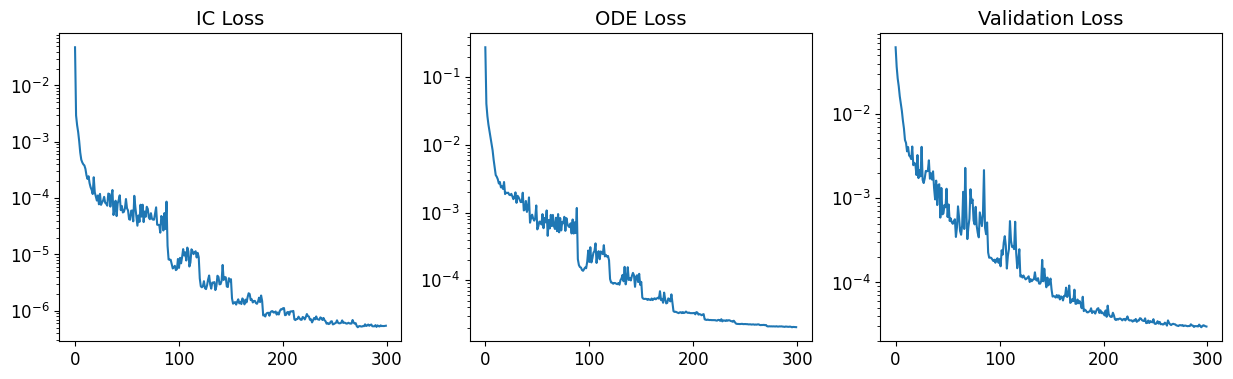

In [141]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Validation Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

#### Inspect accuracy on test set

In [143]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('NN_model.keras')

In [144]:
# Make prediction
pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False):.4e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
RMSE: 1.4519e-03


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Convergence display

In [145]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Define the initialization function
def init():
    # Set up the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {0}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax,

# Define the update function
def update(epoch):
    # Clear the previous frame
    ax.cla()

    # Plot the loss convergence
    pred, = ax.plot(np.linspace(0, 1, 100), pred_profiles[epoch].flatten(), label="Prediction")
    truth, = ax.plot(np.linspace(0, 1, 100), y_test[25*100:(25+1)*100, :], label="Ground Truth")
    ax.legend(prop={'size': 12})

    # Set the axes limits (if necessary)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {epoch}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return line,


# Create the animation
n_epochs = len(loss_tracker.loss_history['IC_loss'])  # Replace with the total number of epochs
frames = range(0, n_epochs, 2)
animation = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)

# Display the animation
plt.show()

<IPython.core.display.Javascript object>

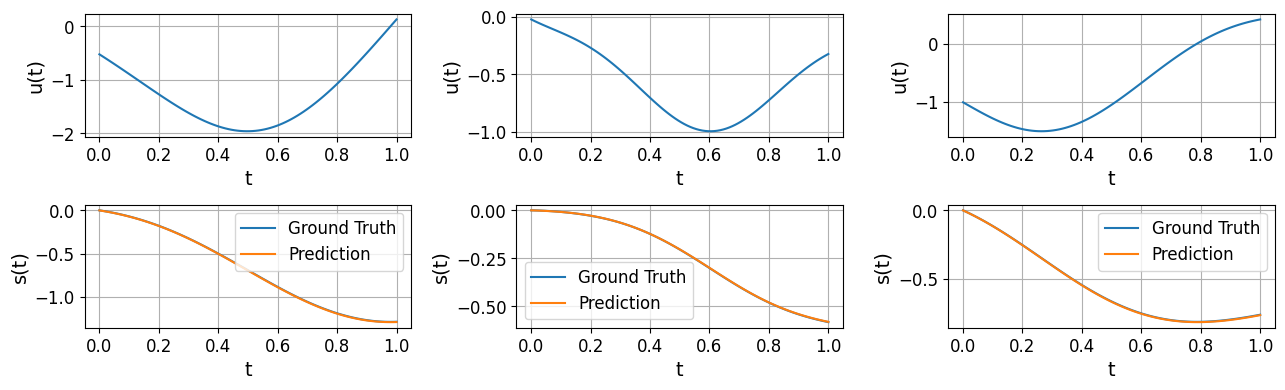

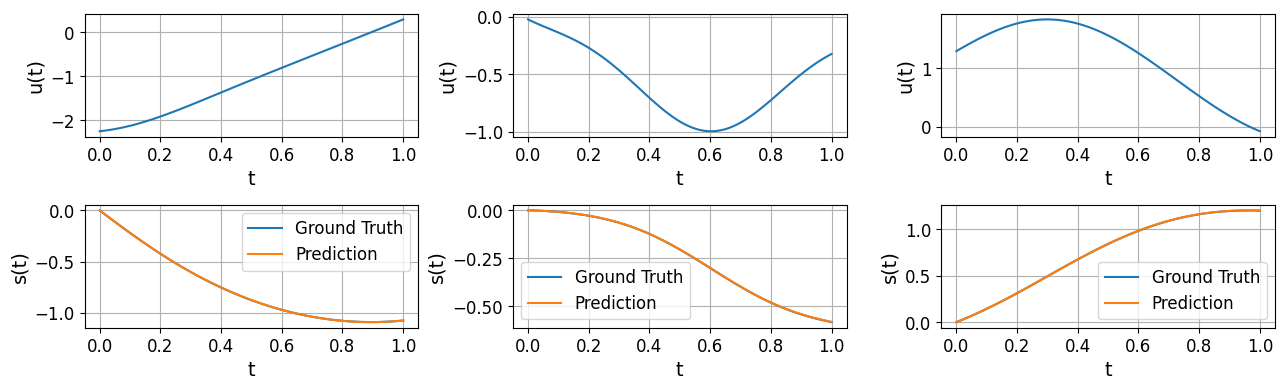

In [147]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig('testing.png', bbox_inches='tight', transparent=True)

#### Out-of-distribution prediction

In [148]:
# Create test dataset
N_test = 100
length_scale_test = 0.2
X, y = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 422.16it/s]


In [149]:
# Make prediction
pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y.flatten(), pred.flatten(), squared=False):.4e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
RMSE: 5.2432e-02


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


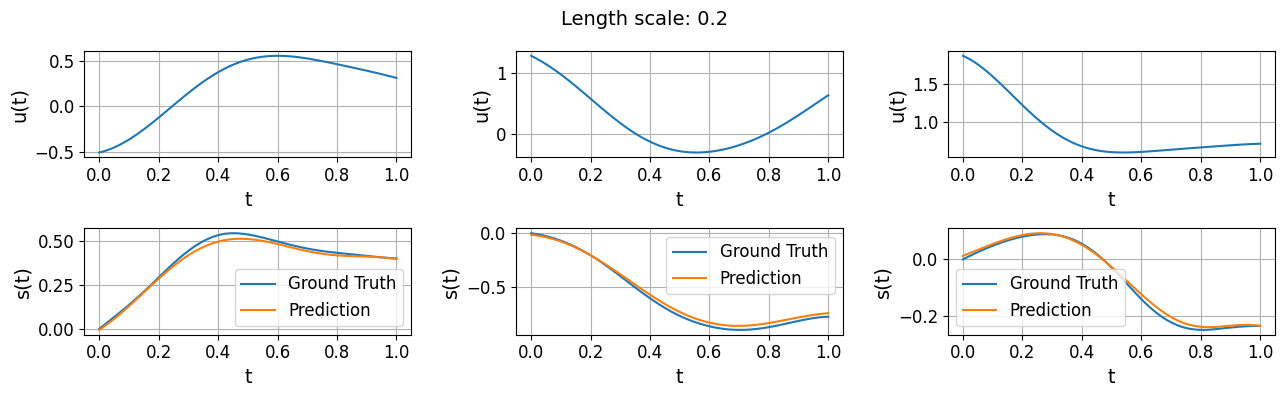

In [150]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

fig.suptitle(f'Length scale: {length_scale_test}', fontsize=14)
plt.tight_layout()
plt.savefig('testing_OOD.png', bbox_inches='tight', transparent=True)

#### Barplot for generalization capability

In [151]:
length_scale_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
RMSE = []
for length_scale in length_scale_list:
    # Create test dataset
    N_test = 100
    X, y = generate_dataset(N_test, length_scale, ODE_solve=True)

    # Make prediction
    pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

    # Overall accuarcy
    RMSE.append(mean_squared_error(y.flatten(), pred.flatten(), squared=False))

100%|██████████| 100/100 [00:00<00:00, 342.58it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 455.33it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 454.60it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 478.14it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 517.86it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 448.43it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 452.81it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


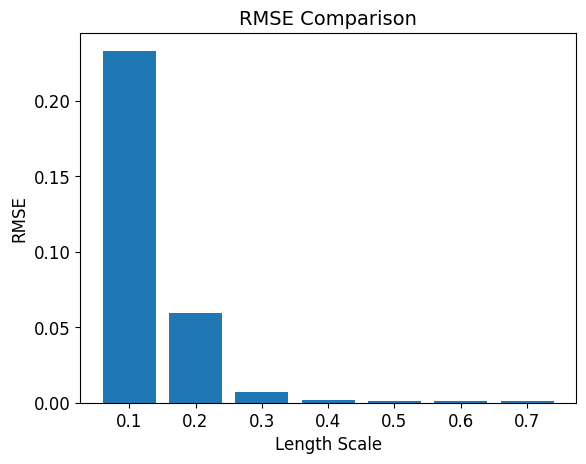

In [152]:
# Generate bar plot
plt.bar(range(len(RMSE)), RMSE)

# Set x-axis tick labels
plt.xticks(range(len(RMSE)), length_scale_list)

# Set x and y axis labels
plt.xlabel('Length Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Set a title for the plot
plt.title('RMSE Comparison', fontsize=14)

# Save the plot
plt.savefig('testing_OOD_bar.png', bbox_inches='tight', transparent=True)